In [175]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

hrv_middle_data_path = 'hrv-middle-data/'
measurement = 'CVSD_diff'

res = pd.DataFrame([], columns=['pcode', 'RMSSD_diff', 'CVSD_diff', 'SDNN_diff'])

for p_index in range(80):
    participant_key = 'P' + str(p_index + 1).zfill(2)
    file_path = hrv_middle_data_path + participant_key + '_hrv_result.csv'

    if not os.path.isfile(file_path):
        print(file_path + ' do not exist!')
        continue

    df = pd.read_csv(file_path)
    
    if len(df) < 10:
        print(file_path + ' has too less data!')
        continue

    df['RMSSD_diff'] = df['HRV_RMSSD_after'] - df['HRV_RMSSD_before']
    df['CVSD_diff'] = df['HRV_CVSD_after'] - df['HRV_CVSD_before']
    df['SDNN_diff'] = df['HRV_SDNN_after'] - df['HRV_SDNN_before']

    res.loc[len(res)] = [participant_key, df['RMSSD_diff'].mean(), df['CVSD_diff'].mean(), df['SDNN_diff'].mean()]
    # res.loc[len(res)] = [participant_key, df['RMSSD_diff'].median(), df['CVSD_diff'].median(), df['SDNN_diff'].median()]

# res.to_csv('hrv_result.csv', index=False)

res


hrv-middle-data/P01_hrv_result.csv has too less data!
hrv-middle-data/P06_hrv_result.csv has too less data!
hrv-middle-data/P07_hrv_result.csv do not exist!
hrv-middle-data/P10_hrv_result.csv has too less data!
hrv-middle-data/P27_hrv_result.csv do not exist!
hrv-middle-data/P29_hrv_result.csv has too less data!
hrv-middle-data/P48_hrv_result.csv has too less data!
hrv-middle-data/P49_hrv_result.csv has too less data!
hrv-middle-data/P56_hrv_result.csv has too less data!
hrv-middle-data/P59_hrv_result.csv do not exist!
hrv-middle-data/P65_hrv_result.csv do not exist!
hrv-middle-data/P74_hrv_result.csv has too less data!
hrv-middle-data/P75_hrv_result.csv has too less data!
hrv-middle-data/P76_hrv_result.csv has too less data!


,pcode,RMSSD_diff,CVSD_diff,SDNN_diff
0,P02,-24.306978,-0.029309,-6.871857
1,P03,-17.578417,-0.023797,-17.016129
2,P04,23.228160,0.028097,-0.606757
3,P05,-27.178595,-0.039443,-31.081707
4,P08,-25.482238,-0.033128,-17.671719
...,...,...,...,...
61,P73,4.082369,0.006900,-13.722092
62,P77,-10.143200,-0.020389,-16.311333
63,P78,-6.780544,-0.013128,-9.303077
64,P79,3.321661,0.001903,-0.345024


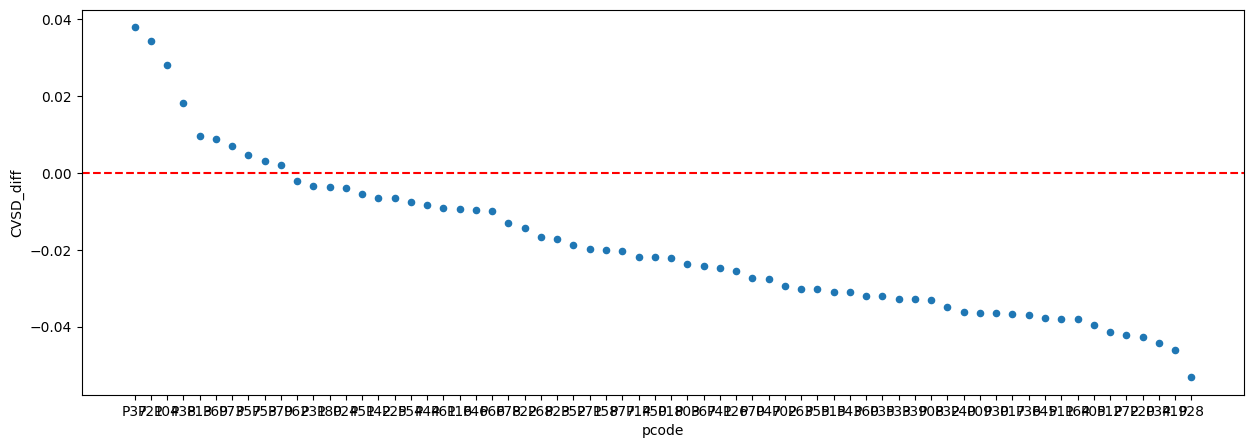

In [176]:

res.sort_values(by=measurement, ascending=False, inplace=True)
# res = res[4:64]
plot = res.plot(x='pcode', y=measurement, kind='scatter', figsize=(15, 5))


plot.axhline(0, color='red', linestyle='--', label='y=0 line')

In [177]:
# res.sort_values(by='CVSD_diff', ascending=False, inplace=True)
# plot = res.plot(x='pcode', y='CVSD_diff', kind='scatter', figsize=(15, 5))
# 
# plot.axhline(0, color='red', linestyle='--', label='y=0 line')
# 
# res.plot(x='pcode', y='RMSSD_diff', kind='scatter', color='orange', label='RMSSD_diff', ax=plot)
# 
# 
# plt.show()

In [178]:
df_subj = pd.read_csv('dataset/SubjData/UserInfo.csv')
df_subj

,pcode,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,P01,2019-05-08,27,M,11,11,3,4,13,13,0,1
1,P02,2019-05-08,21,M,14,5,12,14,5,27,6,18
2,P03,2019-05-08,24,F,10,15,8,7,11,18,2,6
3,P04,2019-05-08,23,M,12,11,8,6,11,20,1,9
4,P05,2019-05-08,27,F,10,11,13,10,6,25,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...
72,P76,2019-04-30,18,M,8,8,12,6,8,21,14,21
73,P77,2019-04-30,18,M,11,12,7,11,10,7,2,7
74,P78,2019-04-30,17,M,12,11,9,12,10,10,2,7
75,P79,2019-04-30,23,M,9,10,7,12,11,13,2,6


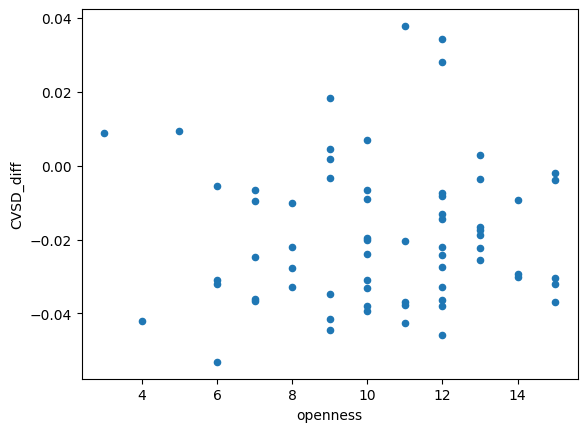

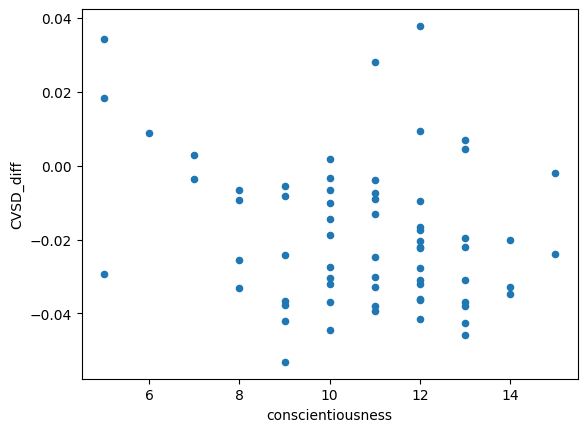

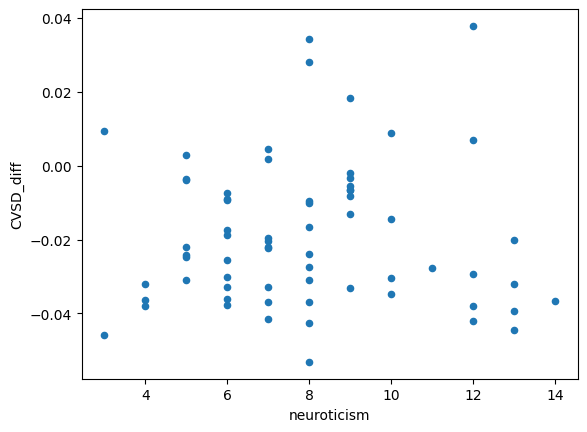

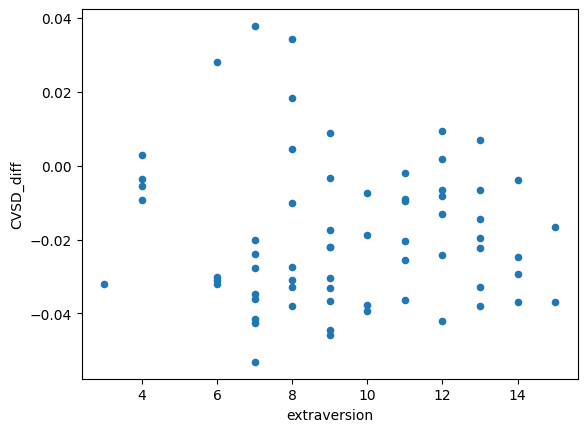

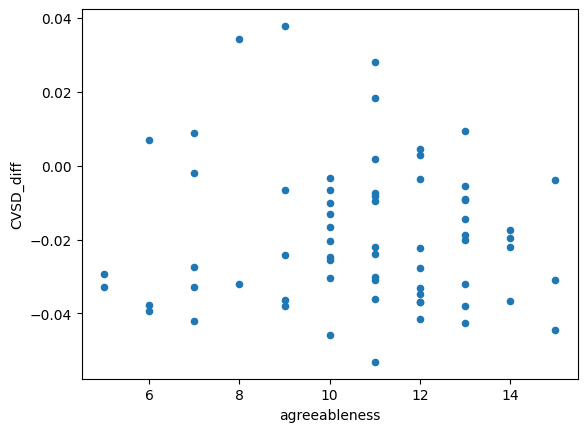

In [179]:
personality_traits = ['openness', 'conscientiousness', 'neuroticism', 'extraversion', 'agreeableness']
df_test = pd.merge(res, df_subj, on='pcode')

for trait in personality_traits:
    df_test.plot(x=trait, y=measurement, kind='scatter')


In [180]:
import statsmodels.api as sm

X = df_test[personality_traits]
y = df_test[measurement]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              CVSD_diff   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.9098
Date:                Tue, 28 May 2024   Prob (F-statistic):              0.481
Time:                        14:58:15   Log-Likelihood:                 168.95
No. Observations:                  66   AIC:                            -325.9
Df Residuals:                      60   BIC:                            -312.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0065      0.02

In [181]:
df_corr = df_test[personality_traits + ['CVSD_diff', 'RMSSD_diff']]
print(df_corr.corr(method='pearson'))

                   openness  conscientiousness  neuroticism  extraversion  \
openness           1.000000          -0.001890    -0.215163      0.122846   
conscientiousness -0.001890           1.000000    -0.089928      0.068655   
neuroticism       -0.215163          -0.089928     1.000000      0.013625   
extraversion       0.122846           0.068655     0.013625      1.000000   
agreeableness      0.076431           0.170632    -0.226964     -0.200421   
CVSD_diff          0.029821          -0.260200     0.002705     -0.054739   
RMSSD_diff         0.032637          -0.225899     0.004262     -0.080886   

                   agreeableness  CVSD_diff  RMSSD_diff  
openness                0.076431   0.029821    0.032637  
conscientiousness       0.170632  -0.260200   -0.225899  
neuroticism            -0.226964   0.002705    0.004262  
extraversion           -0.200421  -0.054739   -0.080886  
agreeableness           1.000000  -0.038363   -0.071070  
CVSD_diff              -0.038363   